In [89]:
PATH = "/home/dilawar/federated/history/logdir/main_test_fed_rfa" # Absolute path to the experiment folder

In [90]:
import tensorflow as tf
import sys
import os
sys.path.append("../")

from federated.data.data_preprocessing import load_data
import numpy as np
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
import pandas as pd

pd.options.plotting.backend = "plotly"

%matplotlib inline

In [91]:
import nest_asyncio
nest_asyncio.apply()

In [92]:
"""
Function that evaluates the model.
Prints accuracy and loss value
"""
def evaluation(X, y, model):
    scores = model.evaluate(X, y, verbose=0)
    print(f"Accuracy: {scores[1]*100}%, Loss: {scores[0]}")

In [93]:
LABELS = ["N", "S", "V", " F", "U"]

In [94]:
"""
Function that creates confusion matrix based upon the dataset and the model.
Displays the confusion matrix.
"""

def make_confusion_matrix(X,y, model):
    y_pred = model.predict(X)
    y_test = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    cnf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,5))
    cnf_matrix =  cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    ticks = np.arange(len(LABELS))
    plt.xticks(ticks, LABELS, rotation=45)
    plt.yticks(ticks, LABELS)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j], '.2f'), horizontalalignment="center",
                    color="white" if cnf_matrix[i, j] > cnf_matrix.max()/2 else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    plt.savefig(f"{PATH}/images/confusion_matrix.pdf", bbox_inches='tight')

    plt.show()

    return y_test, y_pred

In [95]:
"""
Function that loads model and dataset for analysis
Returns x_test, y_test and model
"""
def load(name):
    model = tf.keras.models.load_model(PATH)
    X_test, y_test = load_data(data_analysis=True)

    X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
    evaluation(X_test, y_test, model)
    
    return X_test, y_test, model

In [96]:
def dataframe_from_event(path, type, moments=False):

    path += f"/{type}/"
    event_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    event_files = list(filter(lambda f: "empty" not in f, event_files))
    path += event_files[0]

    if moments:
        condition = lambda x : "privacy_loss" in x
    else:
        condition = lambda x : "loss" in x or "accuracy" in  x

    metrics = defaultdict(list)
    for e in summary_iterator(path):
        for v in e.summary.value:
            if isinstance(v.simple_value, float) and condition(v.tag):
                if v.simple_value == 0.0:
                    metrics[f"{v.tag}_{type}"].append(tf.make_ndarray(v.tensor))
                else:
                    metrics[f"{v.tag}_{type}"].append(v.simple_value)

    metrics_df = pd.DataFrame({k: v for k,v in metrics.items()})

    return metrics_df

In [97]:
def plot_graph(type, moments=False):
    
    if type not in ["accuracy", "loss", "moments_accountant"]:
        raise ValueError(f"type must be accuracy or loss, not {type}")

    path = PATH
    if moments:
        moments_df = dataframe_from_event(path, type)
        moments_df= moments_df.rename(columns={"cumulative_privacy_loss_moments_accountant": "cumulative_privacy_loss"})
        return moments_df
    else:
        train_df = dataframe_from_event(path, "train")
        validation_df = dataframe_from_event(path, "validation")

        cols = list(train_df.columns) + list(validation_df.columns)

        return pd.concat([train_df, validation_df], axis=1)[[col for col in cols if type in col]]

In [98]:
X_test, y_test, model_centralized = load(PATH)

Accuracy: 13.297094404697418%, Loss: 1.731075406074524


In [99]:
model_centralized.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 186)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                9350      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 255       
Total params: 14,705
Trainable params: 14,705
Non-trainable params: 0
_________________________________________________________________


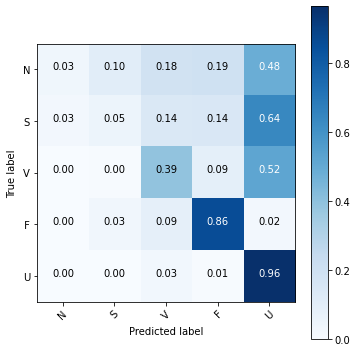

In [100]:
y_test, y_pred = make_confusion_matrix(X_test, y_test, model_centralized)

In [101]:
print(classification_report(y_test, y_pred, target_names=LABELS))

              precision    recall  f1-score   support

           N       0.98      0.03      0.07     18118
           S       0.02      0.05      0.02       556
           V       0.14      0.39      0.21      1448
           F       0.04      0.86      0.07       162
           U       0.14      0.96      0.24      1608

    accuracy                           0.13     21892
   macro avg       0.26      0.46      0.12     21892
weighted avg       0.83      0.13      0.09     21892



In [102]:
metrics_df = plot_graph("accuracy")
metrics_df = metrics_df.copy()

for col in metrics_df.columns:
    if "validation" in col: 
        metrics_df.rename(columns={col: 'Validation Accuracy'}, inplace=True)
    else:
        metrics_df.rename(columns={col: 'Training Accuracy'}, inplace=True)

fig = metrics_df.plot(labels=dict(index="Epoch", value="Accuracy"))
fig.show()

fig.write_image(f"{PATH}/images/accuracy.pdf")

  Training Accuracy Validation Accuracy
0        0.21793118         0.022519642
1         0.1839855          0.06376759
2        0.43578818          0.28343686


In [103]:
metrics_df = plot_graph("loss")
metrics_df = metrics_df.copy()

for col in metrics_df.columns:
    if "validation" in col: 
        metrics_df.rename(columns={col: 'Validation Loss'}, inplace=True)
    else:
        metrics_df.rename(columns={col: 'Training Loss'}, inplace=True)

metrics_df.index += 1

fig = metrics_df.plot(labels=dict(index="Epoch", value="Loss", variable=""))
fig.show()

fig.write_image(f"{PATH}/images/loss.pdf")

In [104]:
try:
    metrics_df = plot_graph("moments_accountant", moments=True)
    metrics_df = metrics_df.copy()

    metrics_df.rename(columns={"cumulative_privacy_loss": "Privacy Loss"}, inplace=True)

    fig = metrics_df.plot(labels=dict(index="Epoch", value="ε", variable=""))
    fig.show()

    fig.write_image(f"{PATH}/images/moments_accountant.pdf")
except:
    print("No moments accountant.")

No moments accountant.
